In [1]:
# Importing the libraries we'll be using for this project
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, RocCurveDisplay
from sklearn.model_selection import GridSearchCV


In [2]:
# load in database and split as neccessary
df = pd.read_csv('database.csv')
# Splitting the training data into appropriate training and validation sets
X = df.drop(columns = ["Diff","date","Unnamed: 0"])

y = df[['Diff']]
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 42)

In [3]:
#Create a random forest pipeline
randomforest_pipeline = Pipeline(steps = [
    ('data_scaling', StandardScaler()),
    ('model', RandomForestClassifier(max_depth = 60,
                                     min_samples_leaf = 3,
                                     min_samples_split = 4,
                                     n_estimators = 300))
])

In [4]:
#train random forest pipeline
randomforest_pipeline.fit(X_train,y_train.values.ravel())

Pipeline(steps=[('data_scaling', StandardScaler()),
                ('model',
                 RandomForestClassifier(max_depth=60, min_samples_leaf=3,
                                        min_samples_split=4,
                                        n_estimators=300))])

Accuracy Score: 0.5140562248995983
ROC AUC Score: 0.49795321637426904


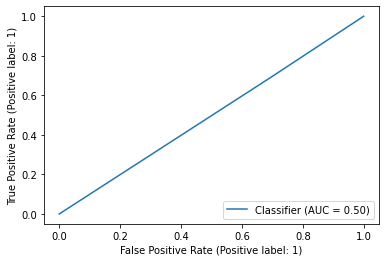

In [5]:
# Saving our pipeline to a binary pickle file
joblib.dump(randomforest_pipeline, 'model/randomforest_pipeline.pkl')

loaded_model = randomforest_pipeline

pipeline_preds = loaded_model.predict(X_val)
val_accuracy = accuracy_score(y_val, pipeline_preds)
val_roc_auc = roc_auc_score(y_val, pipeline_preds)

print(f'Accuracy Score: {val_accuracy}')
print(f'ROC AUC Score: {val_roc_auc}') 

RocCurveDisplay.from_predictions(y_val, pipeline_preds)
plt.show()

In [6]:
# Lets try a boosting model now
from sklearn.ensemble import HistGradientBoostingClassifier
boostingPipeline = Pipeline(steps = [
    ('data_scaling', StandardScaler()),
    ('model', HistGradientBoostingClassifier(loss = "auto",))
])

In [7]:
boostingPipeline.fit(X_train,y_train.values.ravel())

Pipeline(steps=[('data_scaling', StandardScaler()),
                ('model', HistGradientBoostingClassifier())])

Accuracy Score: 0.4779116465863454
ROC AUC Score: 0.4673489278752436


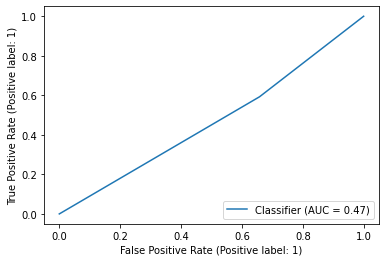

In [8]:
# Saving our pipeline to a binary pickle file
joblib.dump(boostingPipeline, 'model/boostingPipeline.pkl')

loaded_model = boostingPipeline

pipeline_preds = loaded_model.predict(X_val)
val_accuracy = accuracy_score(y_val, pipeline_preds)
val_roc_auc = roc_auc_score(y_val, pipeline_preds)

print(f'Accuracy Score: {val_accuracy}')
print(f'ROC AUC Score: {val_roc_auc}') 

RocCurveDisplay.from_predictions(y_val, pipeline_preds)
plt.show()

In [9]:
#hypertune Gboost
param_grid = [
    {
        "loss": ["deviance","exponential"],
        "learning_rate": [0.01,0.1,1],
        "n_estimators": [100,200,400,800]
    }
]

Accuracy Score: 0.5461847389558233
ROC AUC Score: 0.5187134502923977


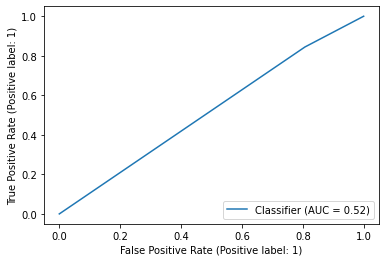

In [10]:
#logistic Regression with cross validation
from sklearn.linear_model import LogisticRegressionCV
lr_pipeline = Pipeline(steps = [
    ('data_scaling', StandardScaler()),
    ('model', LogisticRegressionCV(cv = 10))#10 cross validation
])

lr_pipeline.fit(X_train,y_train.values.ravel())

joblib.dump(lr_pipeline, 'model/lr_pipeline.pkl')

loaded_model = lr_pipeline

pipeline_preds = loaded_model.predict(X_val)
val_accuracy = accuracy_score(y_val, pipeline_preds)
val_roc_auc = roc_auc_score(y_val, pipeline_preds)

print(f'Accuracy Score: {val_accuracy}')
print(f'ROC AUC Score: {val_roc_auc}') 

RocCurveDisplay.from_predictions(y_val, pipeline_preds)
plt.show()

In [11]:
#hypertune LR
param_grid = [
    {
        "penalty": ["none","l2","l1","elasticnet"]
    }
]

Fitting 5 folds for each of 26 candidates, totalling 130 fits
the best parametes are {'model__n_neighbors': 76}
Accuracy Score: 0.5421686746987951
ROC AUC Score: 0.511598440545809


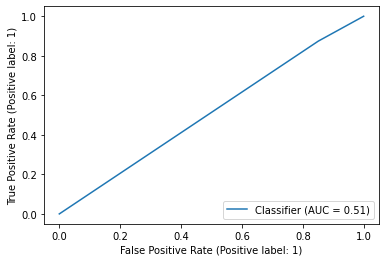

['model/knnc_pipeline.pkl']

In [43]:
#k nearest neighbors classifier
from sklearn.neighbors import KNeighborsClassifier

knnc_pipeline = Pipeline(steps = [
    ('data_scaling', StandardScaler()),
    ('model', KNeighborsClassifier(n_neighbors=15))#10 cross validation
])

tuned_model = cv_fit_search(knnc_pipeline,param_grid,X_train,y_train,X_val,y_val,5)

joblib.dump(tuned_model, 'model/knnc_pipeline.pkl')


In [41]:
#

In [42]:
#

In [40]:
def cv_fit_search(pipeline, param_grid, X_train,y_train,X_test,y_test,cv):
    """ a function to fit the data and do hyper parameter tuning
    Args:
        pipeline: a predefined pipeline
        param grid: a list of parameters that match the pipeline naming convetion
        CV: integer indicating the number of cross validations we want to do
        X_train:X to train on
        y_train: labels for Training Set
        X_test = held out data for final accuacry
        y_test = held out labels
    
    Return
    model: the fitted and hypertuned model,
    
    Prints: AUROC Curve, ACC AUC score of best models, best parameters found

    """
    grid_search = GridSearchCV(pipeline, param_grid, cv=cv, verbose=1,n_jobs=1)
    grid_search.fit(X_train,y_train.values.ravel())

    pipeline_preds = grid_search.predict(X_test)
    val_accuracy = accuracy_score(y_test, pipeline_preds)
    val_roc_auc = roc_auc_score(y_test, pipeline_preds)
    
    print("the best parametes are",grid_search.best_params_)
    print(f'Accuracy Score: {val_accuracy}')
    print(f'ROC AUC Score: {val_roc_auc}') 

    RocCurveDisplay.from_predictions(y_test, pipeline_preds)
    plt.show()
    return grid_search
    
